In [1]:
!git clone https://github.com/swapniel99/ezio.git

Cloning into 'ezio'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 364 (delta 0), reused 3 (delta 0), pack-reused 357
Receiving objects: 100% (364/364), 7.84 MiB | 10.42 MiB/s, done.
Resolving deltas: 100% (145/145), done.


In [2]:
%cd ezio

/content/ezio


In [5]:
import torch
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

!pip install torchsummary
from torchsummary import summary

from ezio.data import dataset 
from ezio.data.data_transforms.session_11 import transformations
from ezio.runner import engine
from ezio.utils import loss, lr_range_test, one_cycle_policy, cyclic_graph
from ezio.utils.misclassified_images import misclassified_images

In [4]:
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-s0rg6syw
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-s0rg6syw
     |████████████████████████████████| 952kB 8.1MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=69177 sha256=b238b7e9b547164a7b478c0efc0fe0271dcc2a335aeeb303deea8310c178a912
  Stored in directory: /tmp/pip-ephem-wheel-cache-jom2u05a/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


## Triangular Curve

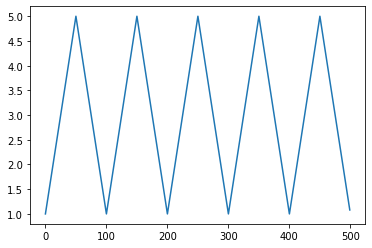

In [6]:
cyclic_graph.draw_graph(num_iterations=500, lr_min=1, lr_max=5, step_size=50)

In [7]:
train_transforms = transformations.perform_transformations(train=True, is_numpy=True)
test_transforms = transformations.perform_transformations(train=False, is_numpy=True)

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [9]:
train_set, valid_set = dataset.cifar10_dataset(train_transforms, test_transforms)

Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified


In [10]:
train_loader, valid_loader = dataset.create_loaders(train_set, valid_set, train_batch_size=512, valid_batch_size=512, num_workers=4)

In [11]:
from ezio.model.session_11.model import Net11
model = Net11().to(device)
torch.save(model.state_dict(), 'model.pt')

In [12]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

## LR Finder Module

In [13]:
all_lrs, all_lr_loss, all_lr_acc = lr_range_test.lr_range(model, train_loader, device)

100%|██████████| 98/98 [00:24<00:00,  3.95it/s]


In [14]:
MAX_LR = all_lrs[all_lr_acc.index(max(all_lr_acc))]
print('MAX_LR:', MAX_LR)

MAX_LR: 0.03377313908791013


Text(0.5, 1.0, 'Accuracy vs Learning_rate')

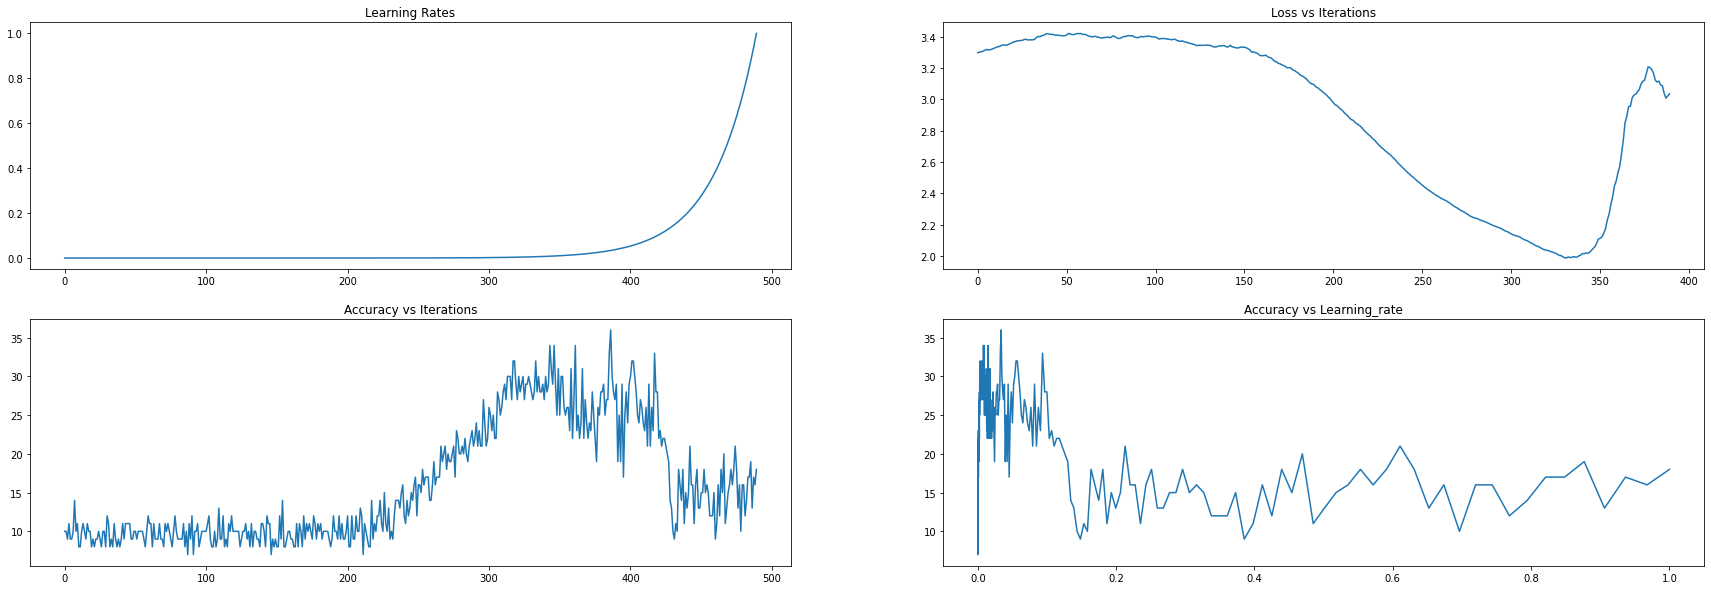

In [15]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(30,10))
axs[0][0].plot(all_lrs)
axs[0][1].plot(all_lr_loss[:-100])
axs[1][0].plot(all_lr_acc)
axs[1][1].plot(all_lrs, all_lr_acc)
axs[0][0].set_title("Learning Rates")
axs[0][1].set_title("Loss vs Iterations")
axs[1][0].set_title("Accuracy vs Iterations")
axs[1][1].set_title("Accuracy vs Learning_rate")

# One cycle LR

In [16]:
model = Net11().to(device)
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [17]:
BATCH_SIZE = 512
NUM_BATCHES = len(train_loader)
TOTAL_EPOCHS = 24
MAX_AT_EPOCH = 5
TOTAL_ITERATIONS = NUM_BATCHES * TOTAL_EPOCHS
MAX_AT_ITERATION = MAX_AT_EPOCH * NUM_BATCHES
MAX_LR = all_lrs[all_lr_acc.index(max(all_lr_acc))]
MIN_LR = MAX_LR / 8

loss_function = loss.cross_entropy_loss()

optimizer = torch.optim.SGD(model.parameters(), lr=1., momentum=0.9)
olr = one_cycle_policy.ocp(TOTAL_ITERATIONS, MAX_AT_ITERATION, min_lr=MIN_LR, max_lr=MAX_LR)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [olr])

In [19]:
train_acc, train_losses, test_acc, test_losses, learning_rate = engine.fit(model, train_loader, valid_loader, loss_function, device, optimizer, TOTAL_EPOCHS, scheduler)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.245406150817871 Batch_id=97 Accuracy=40.00 Learning Rate=0.01013194172637304: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 5151/10000 (51.51%)

EPOCH: 2


Loss=1.1414458751678467 Batch_id=97 Accuracy=58.00 Learning Rate=0.016042241066757314: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 5828/10000 (58.28%)

EPOCH: 3


Loss=0.8800688982009888 Batch_id=97 Accuracy=68.00 Learning Rate=0.021952540407141584: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 6815/10000 (68.15%)

EPOCH: 4


Loss=0.7332402467727661 Batch_id=97 Accuracy=72.00 Learning Rate=0.027862839747525858: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7470/10000 (74.70%)

EPOCH: 5


Loss=0.7283893823623657 Batch_id=97 Accuracy=75.00 Learning Rate=0.03377313908791013: 100%|██████████| 98/98 [00:25<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7620/10000 (76.20%)

EPOCH: 6


Loss=0.5599755644798279 Batch_id=97 Accuracy=79.00 Learning Rate=0.032217797156230056: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 7543/10000 (75.43%)

EPOCH: 7


Loss=0.5317498445510864 Batch_id=97 Accuracy=81.00 Learning Rate=0.030662455224549988: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7692/10000 (76.92%)

EPOCH: 8


Loss=0.4028644561767578 Batch_id=97 Accuracy=84.00 Learning Rate=0.029107113292869916: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8255/10000 (82.55%)

EPOCH: 9


Loss=0.30782991647720337 Batch_id=97 Accuracy=86.00 Learning Rate=0.027551771361189845: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8408/10000 (84.08%)

EPOCH: 10


Loss=0.2938607931137085 Batch_id=97 Accuracy=88.00 Learning Rate=0.02599642942950977: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8652/10000 (86.52%)

EPOCH: 11


Loss=0.2801973819732666 Batch_id=97 Accuracy=89.00 Learning Rate=0.0244410874978297: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8539/10000 (85.39%)

EPOCH: 12


Loss=0.21031293272972107 Batch_id=97 Accuracy=91.00 Learning Rate=0.022885745566149626: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8660/10000 (86.60%)

EPOCH: 13


Loss=0.22626711428165436 Batch_id=97 Accuracy=92.00 Learning Rate=0.021330403634469558: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8830/10000 (88.30%)

EPOCH: 14


Loss=0.23147115111351013 Batch_id=97 Accuracy=92.00 Learning Rate=0.019775061702789483: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8862/10000 (88.62%)

EPOCH: 15


Loss=0.22799764573574066 Batch_id=97 Accuracy=93.00 Learning Rate=0.01821971977110941: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8905/10000 (89.05%)

EPOCH: 16


Loss=0.14799198508262634 Batch_id=97 Accuracy=94.00 Learning Rate=0.01666437783942934: 100%|██████████| 98/98 [00:25<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8892/10000 (88.92%)

EPOCH: 17


Loss=0.2137531340122223 Batch_id=97 Accuracy=94.00 Learning Rate=0.015109035907749268: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8863/10000 (88.63%)

EPOCH: 18


Loss=0.12108419835567474 Batch_id=97 Accuracy=95.00 Learning Rate=0.013553693976069196: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8999/10000 (89.99%)

EPOCH: 19


Loss=0.11955787986516953 Batch_id=97 Accuracy=96.00 Learning Rate=0.011998352044389125: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 9031/10000 (90.31%)

EPOCH: 20


Loss=0.09453881531953812 Batch_id=97 Accuracy=96.00 Learning Rate=0.010443010112709053: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9098/10000 (90.98%)

EPOCH: 21


Loss=0.11695035547018051 Batch_id=97 Accuracy=96.00 Learning Rate=0.008887668181028981: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9095/10000 (90.95%)

EPOCH: 22


Loss=0.07820884138345718 Batch_id=97 Accuracy=97.00 Learning Rate=0.00733232624934891: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9119/10000 (91.19%)

EPOCH: 23


Loss=0.08395980298519135 Batch_id=97 Accuracy=97.00 Learning Rate=0.005776984317668835: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9131/10000 (91.31%)

EPOCH: 24


Loss=0.05633559077978134 Batch_id=97 Accuracy=98.00 Learning Rate=0.004221642385988763: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]



Test set: Average loss: 0.0006, Accuracy: 9145/10000 (91.45%)



[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f26f0160630>


Text(0.5, 1.0, 'Test Losses')

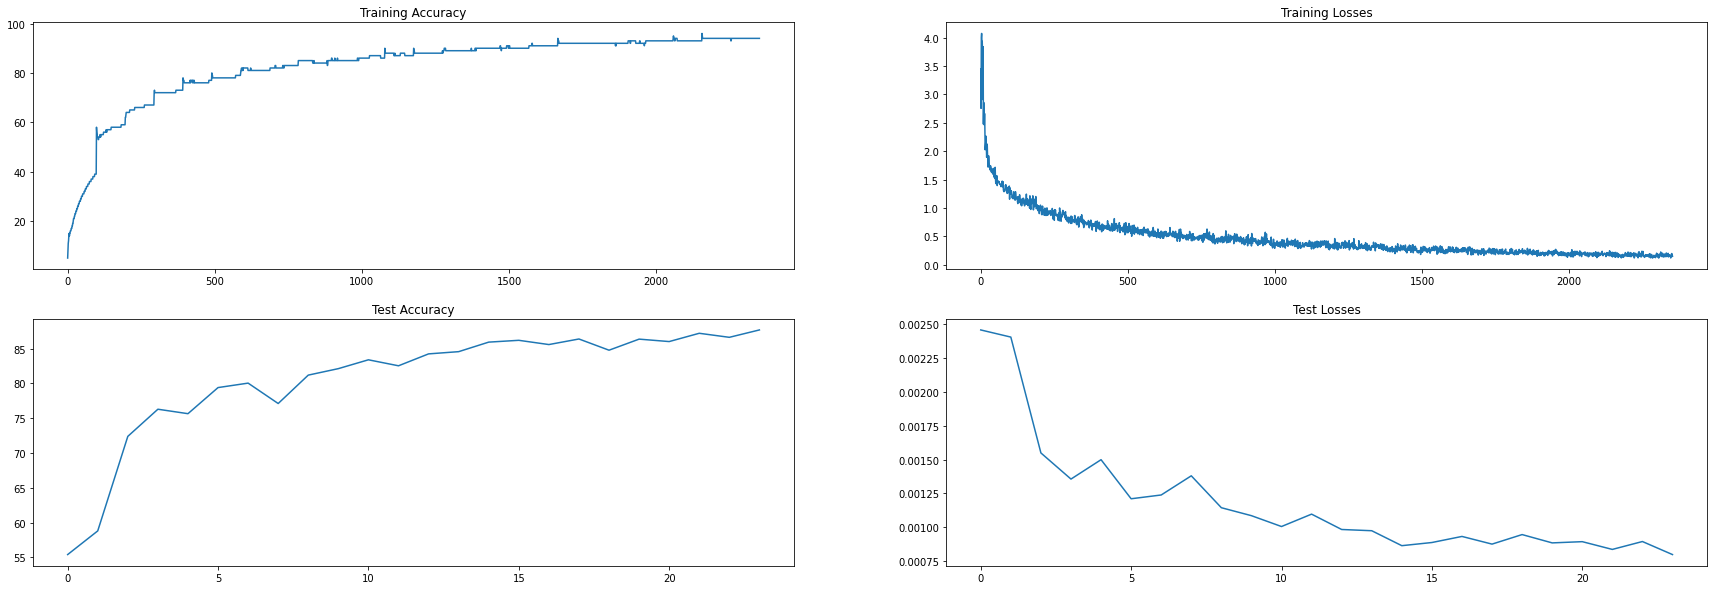

In [20]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(30,10))
print(axs)
axs[0][0].plot(train_acc, label = "train_acc")
axs[0][1].plot(train_losses, label = "train_losses")
axs[1][0].plot(test_acc, label = "test_acc")
axs[1][1].plot(test_losses, label = "test_losses")
# axs[0].legend()
axs[0][0].set_title("Training Accuracy")
axs[0][1].set_title("Training Losses")
axs[1][0].set_title("Test Accuracy")
axs[1][1].set_title("Test Losses")

In [20]:
path = "sample_model.pth"
torch.save(model, path)